In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import untils
from MiniDeepTaxonNet import CobwebNN, CobwebNNTreeLayer, TestModel
import argparse
import os
import sys

In [15]:
# load mnist
download = True
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))

dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, hidden_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_size),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = MLP(28*28, 32)
model.cuda()
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 10

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(mnist_train_loader)):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = criterion(recon_batch, data.view(data.size(0), -1))
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(mnist_train_loader.dataset)))


In [8]:
for epoch in range(1, epochs + 1):
    train(epoch)

  0%|          | 0/469 [00:00<?, ?it/s]/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 469/469 [00:05<00:00, 81.37it/s]


====> Epoch: 1 Average loss: 0.0002


100%|██████████| 469/469 [00:05<00:00, 79.80it/s]


====> Epoch: 2 Average loss: 0.0002


100%|██████████| 469/469 [00:05<00:00, 78.80it/s]


====> Epoch: 3 Average loss: 0.0002


100%|██████████| 469/469 [00:06<00:00, 71.37it/s]


====> Epoch: 4 Average loss: 0.0001


100%|██████████| 469/469 [00:06<00:00, 67.97it/s]


====> Epoch: 5 Average loss: 0.0001


100%|██████████| 469/469 [00:06<00:00, 70.83it/s]


====> Epoch: 6 Average loss: 0.0001


100%|██████████| 469/469 [00:06<00:00, 69.10it/s]


====> Epoch: 7 Average loss: 0.0001


100%|██████████| 469/469 [00:06<00:00, 71.15it/s]


====> Epoch: 8 Average loss: 0.0001


100%|██████████| 469/469 [00:06<00:00, 77.33it/s]


====> Epoch: 9 Average loss: 0.0001


100%|██████████| 469/469 [00:05<00:00, 79.72it/s]

====> Epoch: 10 Average loss: 0.0001


In [9]:
# train a linear classifier
linear_classifier = nn.Linear(32, 10)
linear_classifier.cuda()
linear_classifier.train()
optimizer = optim.Adam(linear_classifier.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()

def train_classifier(epoch):
    linear_classifier.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(tqdm(mnist_train_loader)):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        with torch.no_grad():
            features = model.encoder(data.view(data.size(0), -1)).detach()
        output = linear_classifier(features)
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(mnist_train_loader.dataset)))
    print('====> Accuracy: {:.4f}'.format(correct / len(mnist_train_loader.dataset)))

In [10]:
for epoch in range(1, 10):
    train_classifier(epoch)

  0%|          | 0/469 [00:00<?, ?it/s]/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 469/469 [00:05<00:00, 85.90it/s] 


====> Epoch: 1 Average loss: 0.0040
====> Accuracy: 0.8450


100%|██████████| 469/469 [00:05<00:00, 87.03it/s] 


====> Epoch: 2 Average loss: 0.0033
====> Accuracy: 0.8732


100%|██████████| 469/469 [00:06<00:00, 78.07it/s] 


====> Epoch: 3 Average loss: 0.0033
====> Accuracy: 0.8745


100%|██████████| 469/469 [00:06<00:00, 74.80it/s]


====> Epoch: 4 Average loss: 0.0033
====> Accuracy: 0.8745


100%|██████████| 469/469 [00:06<00:00, 77.34it/s]


====> Epoch: 5 Average loss: 0.0033
====> Accuracy: 0.8754


100%|██████████| 469/469 [00:05<00:00, 81.07it/s] 


====> Epoch: 6 Average loss: 0.0033
====> Accuracy: 0.8756


100%|██████████| 469/469 [00:06<00:00, 77.41it/s]


====> Epoch: 7 Average loss: 0.0033
====> Accuracy: 0.8738


100%|██████████| 469/469 [00:05<00:00, 85.28it/s] 


====> Epoch: 8 Average loss: 0.0033
====> Accuracy: 0.8753


100%|██████████| 469/469 [00:06<00:00, 74.59it/s]

====> Epoch: 9 Average loss: 0.0033
====> Accuracy: 0.8755


In [17]:
# test the classifier
def test_classifier():
    linear_classifier.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in mnist_test_loader:
            data = data.cuda()
            target = target.cuda()
            features = model.encoder(data.view(data.size(0), -1))
            output = linear_classifier(features)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(mnist_test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    print('====> Accuracy: {:.4f}'.format(correct / len(mnist_test_loader.dataset)))
    

In [18]:
test_classifier()

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


====> Test set loss: 0.0015
====> Accuracy: 0.8864


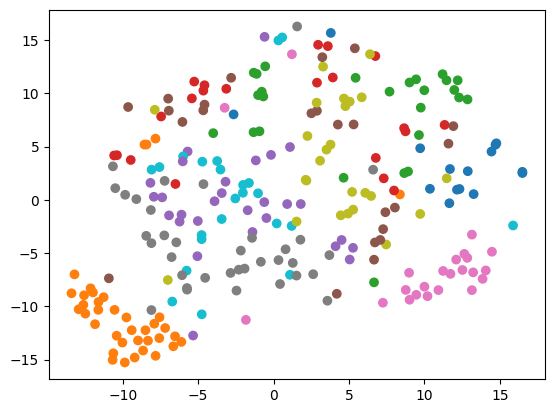

In [16]:
# tsne the features
def tsne_features():
    model.eval()
    tsne = TSNE(n_components=2, random_state=0)
    with torch.no_grad():
        for data, target in mnist_test_loader:
            data = data.cuda()
            features = model.encoder(data.view(data.size(0), -1)).cpu().numpy()
            tsne_features = tsne.fit_transform(features)
            plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=target.cpu().numpy(), cmap='tab10')
            plt.show()
            break

tsne_features()

In [19]:
class MLP_Supervised(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP_Supervised, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, hidden_size),
        )
        self.classifier = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [20]:
model = MLP_Supervised(28*28, 32, 10)
model.cuda()
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 10

def train_supervised(epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(tqdm(mnist_train_loader)):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(mnist_train_loader.dataset)))
    print('====> Accuracy: {:.4f}'.format(correct / len(mnist_train_loader.dataset)))

In [21]:
for epoch in range(1, epochs + 1):
    train_supervised(epoch)

  0%|          | 0/469 [00:00<?, ?it/s]/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 469/469 [00:06<00:00, 77.53it/s]


====> Epoch: 1 Average loss: 0.0035
====> Accuracy: 0.8713


100%|██████████| 469/469 [00:06<00:00, 72.58it/s]


====> Epoch: 2 Average loss: 0.0013
====> Accuracy: 0.9505


100%|██████████| 469/469 [00:05<00:00, 80.38it/s]


====> Epoch: 3 Average loss: 0.0009
====> Accuracy: 0.9657


100%|██████████| 469/469 [00:05<00:00, 84.51it/s]


====> Epoch: 4 Average loss: 0.0007
====> Accuracy: 0.9737


100%|██████████| 469/469 [00:05<00:00, 81.13it/s]


====> Epoch: 5 Average loss: 0.0005
====> Accuracy: 0.9794


100%|██████████| 469/469 [00:05<00:00, 82.51it/s]


====> Epoch: 6 Average loss: 0.0004
====> Accuracy: 0.9828


100%|██████████| 469/469 [00:05<00:00, 82.61it/s]


====> Epoch: 7 Average loss: 0.0003
====> Accuracy: 0.9859


100%|██████████| 469/469 [00:05<00:00, 78.66it/s]


====> Epoch: 8 Average loss: 0.0003
====> Accuracy: 0.9879


100%|██████████| 469/469 [00:06<00:00, 76.93it/s]


====> Epoch: 9 Average loss: 0.0002
====> Accuracy: 0.9904


100%|██████████| 469/469 [00:06<00:00, 74.86it/s]

====> Epoch: 10 Average loss: 0.0002
====> Accuracy: 0.9911


In [22]:
# test the classifier
def test_supervised():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in mnist_test_loader:
            data = data.cuda()
            target = target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(mnist_test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    print('====> Accuracy: {:.4f}'.format(correct / len(mnist_test_loader.dataset)))

test_supervised()

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


====> Test set loss: 0.0003
====> Accuracy: 0.9755


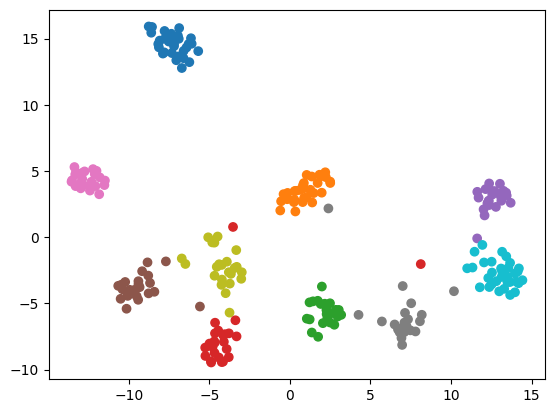

In [23]:
# tsne the features
def tsne_features():
    model.eval()
    tsne = TSNE(n_components=2, random_state=0)
    with torch.no_grad():
        for data, target in mnist_test_loader:
            data = data.cuda()
            features = model.encoder(data.view(data.size(0), -1)).cpu().numpy()
            tsne_features = tsne.fit_transform(features)
            plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=target.cpu().numpy(), cmap='tab10')
            plt.show()
            break

tsne_features()